In [ ]:
from google.colab import drive

# 1. Google Drive 마운트
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 2. 파일 경로 설정 (사용자 지정 경로)
data_root = '/content/drive/MyDrive/Colab Notebooks/datathon/주력_비주력상품 데이터/주력상품'
# file_path = f'{data_root}/2019-Nov.csv'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import os

In [ ]:
sns.set()

# 그래프 기본 설정
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False
import matplotlib as mpl
import matplotlib.font_manager as fm

# 폰트 파일 경로 지정
font_path = '/content/drive/MyDrive/font/NanumGothic.ttf'

# 폰트 등록 및 matplotlib 설정
font_name = fm.FontProperties(fname=font_path).get_name()
fm.fontManager.addfont(font_path)
mpl.rc('font', family=font_name)

In [ ]:
# 데이터 불러오기
top_one_df = pd.read_parquet(f'{data_root}/one_time_buyers_all_events.parquet')
top_multi_df = pd.read_parquet(f'{data_root}/multi_buyers_all_events.parquet')

In [ ]:
# category_lvl1 컬럼 결측치 확인
top_one_df_missing_category_lvl1 = top_one_df['category_lvl1'].isnull().sum()
print(f"Number of missing values in category_lvl1: {top_one_df_missing_category_lvl1}")
top_multi_df_missing_category_lvl1 = top_multi_df['category_lvl1'].isnull().sum()
print(f"Number of missing values in category_lvl1: {top_multi_df_missing_category_lvl1}")

Number of missing values in category_lvl1: 0
Number of missing values in category_lvl1: 0


In [ ]:
# 1500만 행 층화 샘플링 데이터 불러오기
df_sample = pd.read_csv(f'/content/drive/MyDrive/Colab Notebooks/datathon/주력_비주력상품 데이터/층화샘플링/top3_categories.csv')

/tmp/ipython-input-2382825836.py:2: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sample = pd.read_csv(f'/content/drive/MyDrive/Colab Notebooks/datathon/주력_비주력상품 데이터/층화샘플링/top3_categories.csv')


In [ ]:
# 1회 구매 고객만 필터링 -1500
# 구매 이벤트만 필터링하여 user별 구매 횟수 계산
purchase_counts = df_sample[df_sample['event_type'] == 'purchase'].groupby('user_id').size()

# 한 번만 구매한 고객 리스트 추출
one_time_buyers = purchase_counts[purchase_counts == 1].index

# 전체 이벤트에서 구매 1회 고객만 필터링
one_time_df = df_sample[df_sample['user_id'].isin(one_time_buyers)]

In [ ]:
# 퍼널 분석 (view-cart-purchase 단계별 유저 수 및 전환율) -> one_time_df -1500
# 사용자별 event_type 집계
funnel_counts = one_time_df.groupby('event_type')['user_id'].nunique().reindex(['view', 'cart', 'purchase'])

# 전환율 계산 (순차적 전환 기준)
view_to_cart = funnel_counts['cart'] / funnel_counts['view'] if funnel_counts['view'] else 0
cart_to_purchase = funnel_counts['purchase'] / funnel_counts['cart'] if funnel_counts['cart'] else 0
view_to_purchase = funnel_counts['purchase'] / funnel_counts['view'] if funnel_counts['view'] else 0

print(funnel_counts)
print(f"view_to_cart: {view_to_cart}")
print(f"cart_to_purchase: {cart_to_purchase}")
print(f"view_to_purchase: {view_to_purchase}")

event_type
view        152290
cart         75183
purchase    193314
Name: user_id, dtype: int64
view_to_cart: 0.49368310460306
cart_to_purchase: 2.5712461593711344
view_to_purchase: 1.269380786657036


In [ ]:
# 2회 이상 구매 고객 필터링 -1500
# 구매 이벤트만 필터링해서 user_id별 구매 횟수 계산
purchase_counts = df_sample[df_sample['event_type'] == 'purchase'].groupby('user_id').size()

# 2번 이상 구매한 고객 ID 추출
multi_buyers = purchase_counts[purchase_counts >= 2].index

multi_buyer_df = df_sample[df_sample['user_id'].isin(multi_buyers)]

In [ ]:
# 퍼널 분석 (view-cart-purchase 단계별 유저 수 및 전환율) -> multi_buyer_df -1500
# 사용자별 event_type 집계
funnel_counts = multi_buyer_df.groupby('event_type')['user_id'].nunique().reindex(['view', 'cart', 'purchase'])

# 전환율 계산 (순차적 전환 기준)
view_to_cart = funnel_counts['cart'] / funnel_counts['view'] if funnel_counts['view'] else 0
cart_to_purchase = funnel_counts['purchase'] / funnel_counts['cart'] if funnel_counts['cart'] else 0
view_to_purchase = funnel_counts['purchase'] / funnel_counts['view'] if funnel_counts['view'] else 0

print(funnel_counts)
print(f"view_to_cart: {view_to_cart}")
print(f"cart_to_purchase: {cart_to_purchase}")
print(f"view_to_purchase: {view_to_purchase}")

event_type
view        41061
cart        32150
purchase    43382
Name: user_id, dtype: int64
view_to_cart: 0.7829814178904556
cart_to_purchase: 1.349362363919129
view_to_purchase: 1.0565256569494168


In [ ]:
# 샘플 - 1500
# 어느 단계에서 유저가 빠지는지 강조하기 좋은 퍼널형 그래프
import matplotlib.pyplot as plt

# 단계와 전환율 정의 (% 단위)
stages = ['View', 'Cart', 'Purchase']
one_time_rates = [100, 49, 127]     # 실제 분석 결과 기반
multi_rates    = [100, 78, 106]

plt.figure(figsize=(10, 6))

# 선 그래프 그리기
plt.plot(stages, one_time_rates, marker='o', label='1회 구매자', color='#a6cee3', linewidth=2)
plt.plot(stages, multi_rates, marker='o', label='다회 구매자', color='#1f78b4', linewidth=2)

# 각 지점에 값 표시
for i in range(len(stages)):
    plt.text(i, one_time_rates[i] + 1, f'{one_time_rates[i]:.1f}%', ha='center', fontsize=10)
    plt.text(i, multi_rates[i] - 5, f'{multi_rates[i]:.1f}%', ha='center', fontsize=10, color='#1f78b4')

# 시각화 설정
plt.ylim(30, 128)  # y축 고정 → 과장 방지
plt.ylabel('Conversion Rate (%)')
plt.title('구매 퍼널 흐름 비교 (View → Cart → Purchase)', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
df = multi_buyer_df  # 다회 구매자용 전체 데이터 - 층화 샘플링 1500 버전

# 1. event_datetime 생성 (vectorized 방식)
df['event_datetime'] = pd.to_datetime(df['event_date']) + pd.to_timedelta(df['event_hour'], unit='h')

# 2. cart & purchase 이벤트 필터링
df_cart = df[df['event_type'] == 'cart']
df_purchase = df[df['event_type'] == 'purchase']

# 3. 세션별 가장 빠른 cart/purchase 시간 추출
cart_times = df_cart.groupby('user_session')['event_datetime'].min().to_frame(name='cart_time')
purchase_times = df_purchase.groupby('user_session')['event_datetime'].min().to_frame(name='purchase_time')

# 4. 공통 세션만 남기고 merge
merged = pd.merge(cart_times, purchase_times, left_index=True, right_index=True)

# 5. 시간차 계산
cart_hold_time = (merged['purchase_time'] - merged['cart_time']).dt.total_seconds() / 3600

# 6. 음수 제거 (올바른 순서만 필터링)
cart_hold_time = cart_hold_time[cart_hold_time >= 0]

# 7. 결과 출력
print(f"[다회 구매자] 평균 Cart 보유 시간 (시간): {cart_hold_time.mean():.2f}")

/tmp/ipython-input-3585063266.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['event_datetime'] = pd.to_datetime(df['event_date']) + pd.to_timedelta(df['event_hour'], unit='h')


[다회 구매자] 평균 Cart 보유 시간 (시간): 1.38


In [ ]:
cart_hold_time_multi = cart_hold_time # 다회 구매자

In [ ]:
df = one_time_df  # 1회 구매자용 전체 데이터 - 층화 샘플링 1500 버전

# 1. event_datetime 생성 (vectorized 방식)
df['event_datetime'] = pd.to_datetime(df['event_date']) + pd.to_timedelta(df['event_hour'], unit='h')

# 2. cart & purchase 이벤트 필터링
df_cart = df[df['event_type'] == 'cart']
df_purchase = df[df['event_type'] == 'purchase']

# 3. 세션별 가장 빠른 cart/purchase 시간 추출
cart_times = df_cart.groupby('user_session')['event_datetime'].min().to_frame(name='cart_time')
purchase_times = df_purchase.groupby('user_session')['event_datetime'].min().to_frame(name='purchase_time')

# 4. 공통 세션만 남기고 merge
merged = pd.merge(cart_times, purchase_times, left_index=True, right_index=True)

# 5. 시간차 계산
cart_hold_time = (merged['purchase_time'] - merged['cart_time']).dt.total_seconds() / 3600

# 6. 음수 제거 (올바른 순서만 필터링)
cart_hold_time = cart_hold_time[cart_hold_time >= 0]

# 7. 결과 출력
print(f"[1회 구매자] 평균 Cart 보유 시간 (시간): {cart_hold_time.mean():.2f}")

/tmp/ipython-input-2623695839.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['event_datetime'] = pd.to_datetime(df['event_date']) + pd.to_timedelta(df['event_hour'], unit='h')


[1회 구매자] 평균 Cart 보유 시간 (시간): 1.48


In [ ]:
cart_hold_time_one_time = cart_hold_time #1회 구매자

In [ ]:
# 히스토플롯으로 분포 보기 - 층화 샘플링 1500 버전
# 구간 정의
bins = [0, 1, 3, 24, 48, 9999]
labels = ['<1시간', '1~3시간', '3~24시간', '24~48시간', '48시간 이상']

# 카테고리 라벨링
one_time_cut = pd.cut(cart_hold_time_one_time, bins=bins, labels=labels, right=False)
multi_cut = pd.cut(cart_hold_time_multi, bins=bins, labels=labels, right=False)

# 비율 계산
one_time_ratio = one_time_cut.value_counts(normalize=True).sort_index()
multi_ratio = multi_cut.value_counts(normalize=True).sort_index()

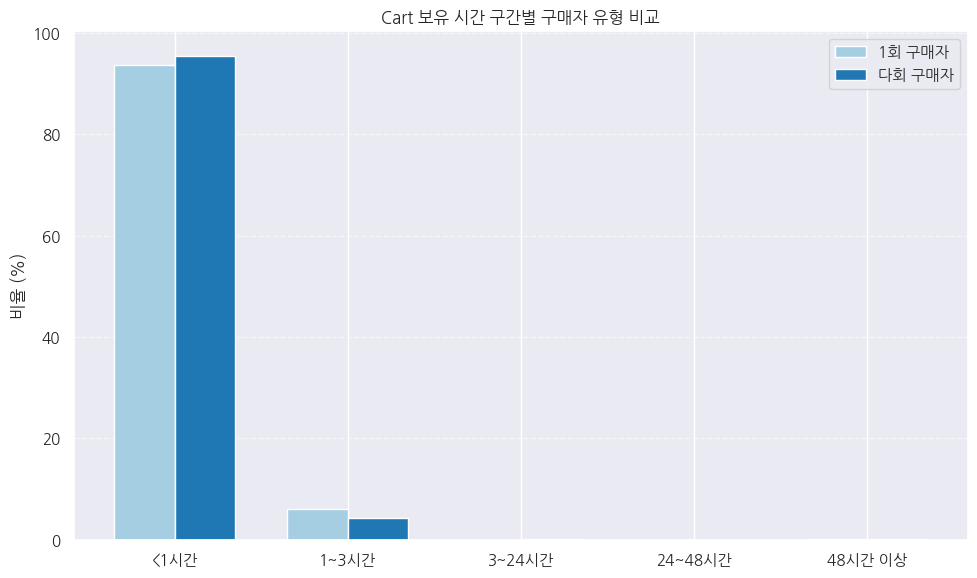

In [ ]:
# 그룹형 막대그래프 - 층화 샘플링 1500 버전
import numpy as np

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(10,6))
plt.bar(x - width/2, one_time_ratio.values * 100, width, label='1회 구매자', color='#a6cee3')
plt.bar(x + width/2, multi_ratio.values * 100, width, label='다회 구매자', color='#1f78b4')

plt.xticks(x, labels)
plt.ylabel('비율 (%)')
plt.title('Cart 보유 시간 구간별 구매자 유형 비교')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
# 1시간 이상 보유한 경우만 필터링 -층화 샘플링 1500 버전
one_time_over1h = cart_hold_time_one_time[cart_hold_time_one_time >= 1]
multi_over1h = cart_hold_time_multi[cart_hold_time_multi >= 1]

print(f"[1회 구매자] 1시간 이상 보유 비율: {len(one_time_over1h) / len(cart_hold_time_one_time) * 100:.2f}%")
print(f"[다회 구매자] 1시간 이상 보유 비율: {len(multi_over1h) / len(cart_hold_time_multi) * 100:.2f}%")

[1회 구매자] 1시간 이상 보유 비율: 6.28%
[다회 구매자] 1시간 이상 보유 비율: 4.48%


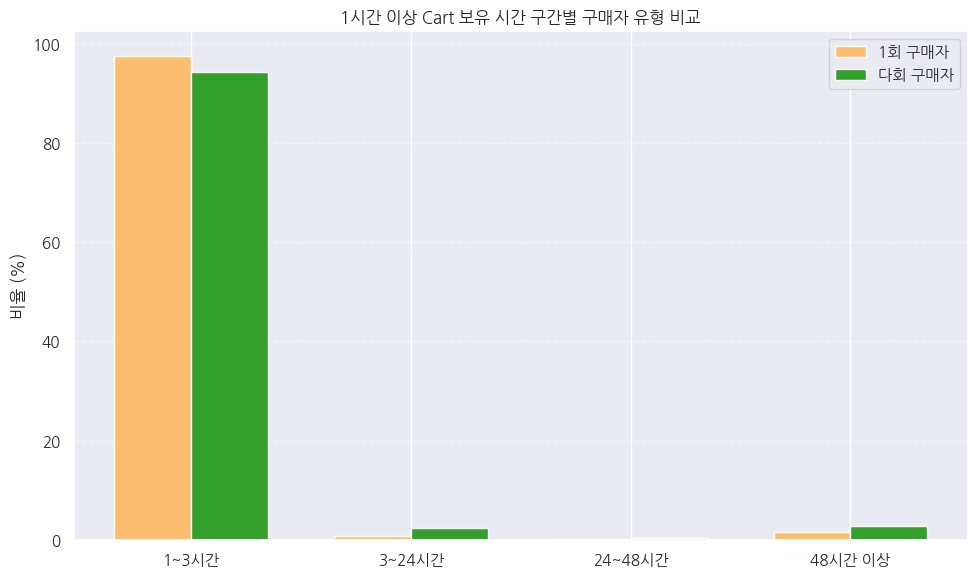

In [ ]:
# 1시간 이상만 다루므로 bins 조정
bins_1hplus = [1, 3, 24, 48, 9999]
labels_1hplus = ['1~3시간', '3~24시간', '24~48시간', '48시간 이상']

# cut
one_time_cut_1hplus = pd.cut(one_time_over1h, bins=bins_1hplus, labels=labels_1hplus, right=False)
multi_cut_1hplus = pd.cut(multi_over1h, bins=bins_1hplus, labels=labels_1hplus, right=False)

# 비율
one_time_ratio_1hplus = one_time_cut_1hplus.value_counts(normalize=True).sort_index()
multi_ratio_1hplus = multi_cut_1hplus.value_counts(normalize=True).sort_index()

import numpy as np
import matplotlib.pyplot as plt

x = np.arange(len(labels_1hplus))
width = 0.35

plt.figure(figsize=(10,6))
plt.bar(x - width/2, one_time_ratio_1hplus.values * 100, width, label='1회 구매자', color='#fdbf6f')
plt.bar(x + width/2, multi_ratio_1hplus.values * 100, width, label='다회 구매자', color='#33a02c')

plt.xticks(x, labels_1hplus)
plt.ylabel('비율 (%)')
plt.title('1시간 이상 Cart 보유 시간 구간별 구매자 유형 비교')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

# -------------------------------------------------------------------
# 1) 분석 대상 카테고리 지정
# -------------------------------------------------------------------
target_categories = ['electronics', 'appliances', 'construction']

# -------------------------------------------------------------------
# 2) Cart 보유 시간 계산 함수 정의
# -------------------------------------------------------------------
def calculate_cart_hold_hours(df, category_name):
    # 2.1) 해당 카테고리 필터링
    cat = df[df['category_lvl1'] == category_name].copy()

    # 2.2) 타입 변환
    cat['event_date'] = pd.to_datetime(cat['event_date'])
    cat['event_hour'] = cat['event_hour'].astype(int)

    # 2.3) event_datetime 생성
    cat['event_datetime'] = cat['event_date'] + pd.to_timedelta(cat['event_hour'], unit='h')

    # 2.4) cart / purchase 시점 추출
    carts = (
        cat[cat['event_type'] == 'cart']
        .groupby('user_id')['event_datetime']
        .min()
        .rename('event_cart')
        .reset_index()
    )
    purchases = (
        cat[cat['event_type'] == 'purchase']
        .groupby('user_id')['event_datetime']
        .min()
        .rename('event_purchase')
        .reset_index()
    )

    # 2.5) user_id 기준 매칭 후 "purchase >= cart" 필터링
    merged = pd.merge(carts, purchases, on='user_id')
    merged = merged[merged['event_purchase'] >= merged['event_cart']]

    # 2.6) 보유 시간 계산 (단위: 시간)
    hold_hours = (merged['event_purchase'] - merged['event_cart']).dt.total_seconds() / 3600.0

    return hold_hours

# -------------------------------------------------------------------
# 3) 1회/다회 구매자 데이터 준비
# -------------------------------------------------------------------
one_time_target  = one_time_df[one_time_df['category_lvl1'].isin(target_categories)].copy()
multi_time_target = multi_buyer_df[multi_buyer_df['category_lvl1'].isin(target_categories)].copy()

# -------------------------------------------------------------------
# 4) 카테고리별 평균 Cart 보유 시간 계산 및 요약
# -------------------------------------------------------------------
results = []
for cat in target_categories:
    one_hold   = calculate_cart_hold_hours(one_time_target, cat)
    multi_hold = calculate_cart_hold_hours(multi_time_target, cat)

    results.append({
        '카테고리': cat,
        '1회 구매자 평균(시간)': round(one_hold.mean(), 2),
        '다회 구매자 평균(시간)': round(multi_hold.mean(), 2)
    })

cart_hold_summary_df = pd.DataFrame(results)

# -------------------------------------------------------------------
# 5) 결과 출력
# -------------------------------------------------------------------
print("📊 카테고리별 1회 vs 다회 구매자 평균 Cart 보유 시간")
display(cart_hold_summary_df)

📊 카테고리별 1회 vs 다회 구매자 평균 Cart 보유 시간


,카테고리,1회 구매자 평균(시간),다회 구매자 평균(시간)
0,electronics,186.76,268.72
1,appliances,228.89,329.84
2,construction,210.04,282.56


In [ ]:
# construction 빼고 나머지 두 카테고리는 원본 데이터와 달리, 다회 구매자 평균 시간이 더 높게 나옴

In [ ]:
# 이상치 때문에 다시
import pandas as pd
import numpy as np

def calculate_cart_hold_hours(df, category_name, max_hours=48):
    # 1) 해당 카테고리만 필터
    cat = df[df['category_lvl1'] == category_name].copy()

    # 2) 타입 변환
    cat['event_date'] = pd.to_datetime(cat['event_date'])
    cat['event_hour'] = cat['event_hour'].astype(int)

    # 3) event_dt 생성
    cat['event_dt'] = cat['event_date'] + pd.to_timedelta(cat['event_hour'], unit='h')

    # 4) 유저별로 cart → purchase 매칭
    hold_list = []
    for user_id, grp in cat.groupby('user_id'):
        carts = np.sort(grp.loc[grp['event_type']=='cart',    'event_dt'].values)
        buys  = np.sort(grp.loc[grp['event_type']=='purchase','event_dt'].values)
        if len(buys) == 0 or len(carts) == 0:
            continue

        # 각 cart 시간에 대해, buys 배열에서 첫 번째 이후 시점 찾기
        idxs = np.searchsorted(buys, carts, side='left')
        for cart_time, idx in zip(carts, idxs):
            if idx < len(buys):
                # numpy.timedelta64 를 시간(h) 단위로 변환
                delta_h = (buys[idx] - cart_time) / np.timedelta64(1, 'h')
                # 0~max_hours 범위만 사용
                if 0 <= delta_h <= max_hours:
                    hold_list.append(delta_h)

    return pd.Series(hold_list, name='hold_h')

# -------------------------------------------------------------------
# 3) 1회/다회 구매자용 DataFrame 준비
# -------------------------------------------------------------------
one_time = one_time_df[one_time_df['category_lvl1'].isin(target_categories)]
multi_time = multi_buyer_df[multi_buyer_df['category_lvl1'].isin(target_categories)]

# -------------------------------------------------------------------
# 4) 카테고리별 요약 테이블 작성
# -------------------------------------------------------------------
rows = []
for cat in target_categories:
    one_h  = calculate_cart_hold_hours(one_time,  cat, max_hours=48)
    multi_h = calculate_cart_hold_hours(multi_time,cat, max_hours=48)

    rows.append({
        '카테고리': cat,
        '1회 구매자 평균(시간)':   round(one_h.mean(),   2),
        '다회 구매자 평균(시간)': round(multi_h.mean(), 2),
        '1회 구매자 중앙값(시간)': round(one_h.median(),   2),
        '다회 구매자 중앙값(시간)': round(multi_h.median(), 2),
        '1회 구매자 건수': len(one_h),
        '다회 구매자 건수': len(multi_h),
    })

cart_hold_summary_df = pd.DataFrame(rows)

# -------------------------------------------------------------------
# 5) 결과 출력
# -------------------------------------------------------------------
print("📊 48시간 이내 Cart 보유 시간 (mean & median & count)")
display(cart_hold_summary_df)

📊 48시간 이내 Cart 보유 시간 (mean & median & count)


,카테고리,1회 구매자 평균(시간),다회 구매자 평균(시간),1회 구매자 중앙값(시간),다회 구매자 중앙값(시간),1회 구매자 건수,다회 구매자 건수
0,electronics,4.23,7.77,0.0,0.0,12157,10117
1,appliances,3.23,6.98,0.0,0.0,7919,4996
2,construction,3.95,7.77,0.0,0.0,23048,25669


In [ ]:
# 층화 샘플링 750 데이터 불러오기
df_sampling = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datathon/주력_비주력상품 데이터/층화샘플링/top3_categories_750.csv')

/tmp/ipython-input-3911564163.py:2: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sampling = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datathon/주력_비주력상품 데이터/층화샘플링/top3_categories_750.csv')


In [ ]:
# 1회 구매 고객만 필터링 - 750
# 구매 이벤트만 필터링하여 user별 구매 횟수 계산
purchase_counts = df_sampling[df_sampling['event_type'] == 'purchase'].groupby('user_id').size()

# 한 번만 구매한 고객 리스트 추출
one_time_buyers = purchase_counts[purchase_counts == 1].index

# 전체 이벤트에서 구매 1회 고객만 필터링
one_time_df = df_sampling[df_sampling['user_id'].isin(one_time_buyers)]

In [ ]:
# 퍼널 분석 (view-cart-purchase 단계별 유저 수 및 전환율) -> one_time_df - 750
# 사용자별 event_type 집계
funnel_counts = one_time_df.groupby('event_type')['user_id'].nunique().reindex(['view', 'cart', 'purchase'])

# 전환율 계산 (순차적 전환 기준)
view_to_cart = funnel_counts['cart'] / funnel_counts['view'] if funnel_counts['view'] else 0
cart_to_purchase = funnel_counts['purchase'] / funnel_counts['cart'] if funnel_counts['cart'] else 0
view_to_purchase = funnel_counts['purchase'] / funnel_counts['view'] if funnel_counts['view'] else 0

print(funnel_counts)
print(f"view_to_cart: {view_to_cart}")
print(f"cart_to_purchase: {cart_to_purchase}")
print(f"view_to_purchase: {view_to_purchase}")

event_type
view         78630
cart         32333
purchase    115076
Name: user_id, dtype: int64
view_to_cart: 0.4112043749205138
cart_to_purchase: 3.5590882380230724
view_to_purchase: 1.4635126542032304


In [ ]:
# 2회 이상 구매 고객 필터링 - 750
# 구매 이벤트만 필터링해서 user_id별 구매 횟수 계산
purchase_counts = df_sampling[df_sampling['event_type'] == 'purchase'].groupby('user_id').size()

# 2번 이상 구매한 고객 ID 추출
multi_buyers = purchase_counts[purchase_counts >= 2].index

multi_buyer_df = df_sampling[df_sampling['user_id'].isin(multi_buyers)]

In [ ]:
# 퍼널 분석 (view-cart-purchase 단계별 유저 수 및 전환율) -> multi_buyer_df - 750
# 사용자별 event_type 집계
funnel_counts = multi_buyer_df.groupby('event_type')['user_id'].nunique().reindex(['view', 'cart', 'purchase'])

# 전환율 계산 (순차적 전환 기준)
view_to_cart = funnel_counts['cart'] / funnel_counts['view'] if funnel_counts['view'] else 0
cart_to_purchase = funnel_counts['purchase'] / funnel_counts['cart'] if funnel_counts['cart'] else 0
view_to_purchase = funnel_counts['purchase'] / funnel_counts['view'] if funnel_counts['view'] else 0

print(funnel_counts)
print(f"view_to_cart: {view_to_cart}")
print(f"cart_to_purchase: {cart_to_purchase}")
print(f"view_to_purchase: {view_to_purchase}")

event_type
view        15412
cart        11202
purchase    17123
Name: user_id, dtype: int64
view_to_cart: 0.7268362315079159
cart_to_purchase: 1.5285663274415282
view_to_purchase: 1.1110173890474955


<function matplotlib.pyplot.show(close=None, block=None)>

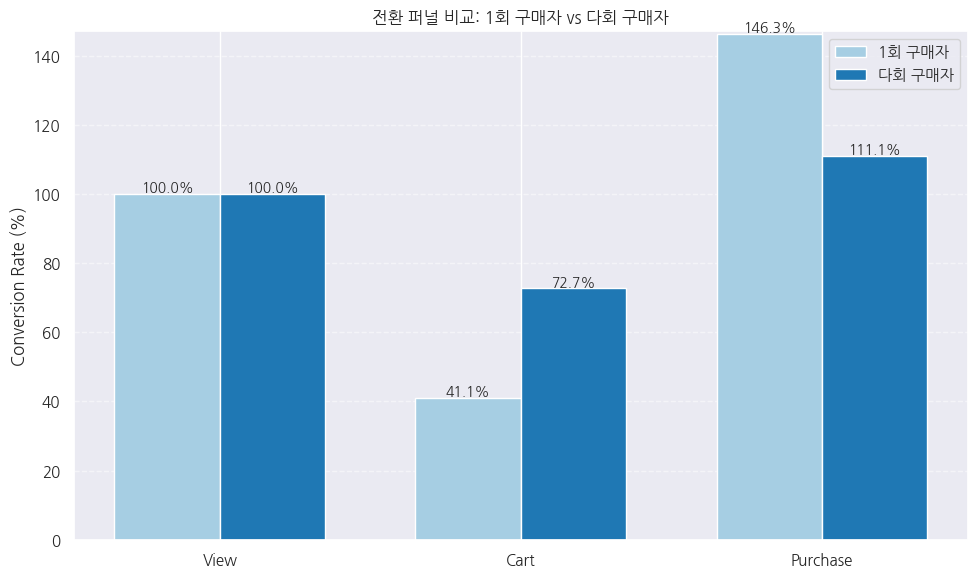

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 단계별 정의
stages = ['View', 'Cart', 'Purchase']
x = np.arange(len(stages))

# 전환율 (View 기준 100%)
one_time_rates = [1.0, 0.411, 1.463]     # 1회 구매자 - 층화 샘플링 750 버전
multi_rates    = [1.0, 0.727, 1.111]     # 다회 구매자

# 막대 너비 설정
width = 0.35

# 시각화
plt.figure(figsize=(10, 6))
bars1 = plt.bar(x - width/2, [r * 100 for r in one_time_rates], width, label='1회 구매자', color='#a6cee3')
bars2 = plt.bar(x + width/2, [r * 100 for r in multi_rates], width, label='다회 구매자', color='#1f78b4')

# 텍스트 라벨링
for i in range(len(stages)):
    plt.text(x[i] - width/2, one_time_rates[i] * 100 + 0.5, f'{one_time_rates[i]*100:.1f}%', ha='center', fontsize=10)
    plt.text(x[i] + width/2, multi_rates[i] * 100 + 0.5, f'{multi_rates[i]*100:.1f}%', ha='center', fontsize=10)

# 그래프 설정
plt.xticks(x, stages)
plt.ylabel('Conversion Rate (%)')
plt.title('전환 퍼널 비교: 1회 구매자 vs 다회 구매자')
plt.ylim(0, 147)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show

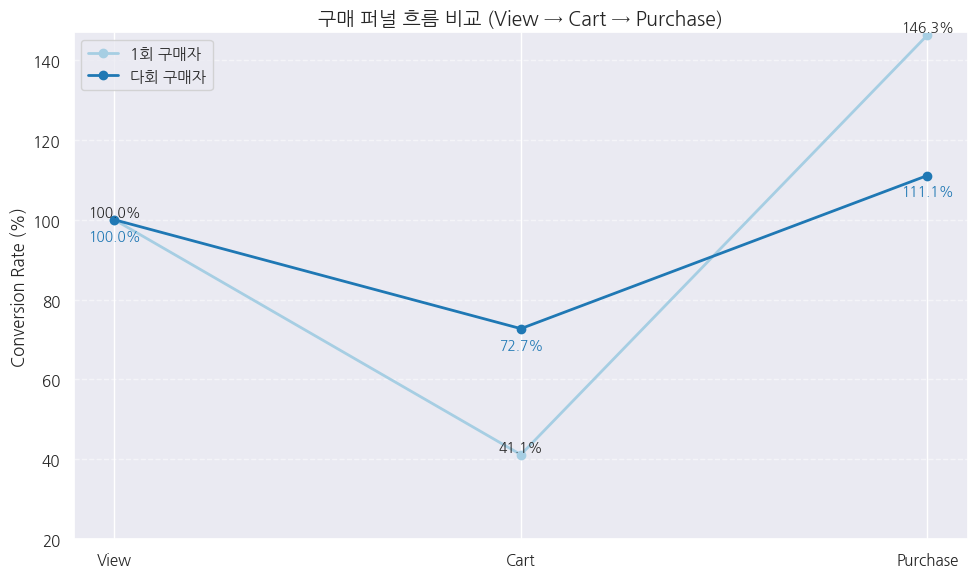

In [ ]:
# 어느 단계에서 유저가 빠지는지 강조하기 좋은 퍼널형 그래프 - 층화 샘플링 750 버전
import matplotlib.pyplot as plt

# 단계와 전환율 정의 (% 단위)
stages = ['View', 'Cart', 'Purchase']
one_time_rates = [100, 41.1, 146.3]     # 1회 구매자 - 층화 샘플링 버전
multi_rates    = [100, 72.7, 111.1]     # 다회 구매자

plt.figure(figsize=(10, 6))

# 선 그래프 그리기
plt.plot(stages, one_time_rates, marker='o', label='1회 구매자', color='#a6cee3', linewidth=2)
plt.plot(stages, multi_rates, marker='o', label='다회 구매자', color='#1f78b4', linewidth=2)

# 각 지점에 값 표시
for i in range(len(stages)):
    plt.text(i, one_time_rates[i] + 1, f'{one_time_rates[i]:.1f}%', ha='center', fontsize=10)
    plt.text(i, multi_rates[i] - 5, f'{multi_rates[i]:.1f}%', ha='center', fontsize=10, color='#1f78b4')

# 시각화 설정
plt.ylim(20, 147)  # y축 고정 → 과장 방지
plt.ylabel('Conversion Rate (%)')
plt.title('구매 퍼널 흐름 비교 (View → Cart → Purchase)', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

view, cart, purchase 전환 퍼널 비교 <원본 데이터>

<function matplotlib.pyplot.show(close=None, block=None)>

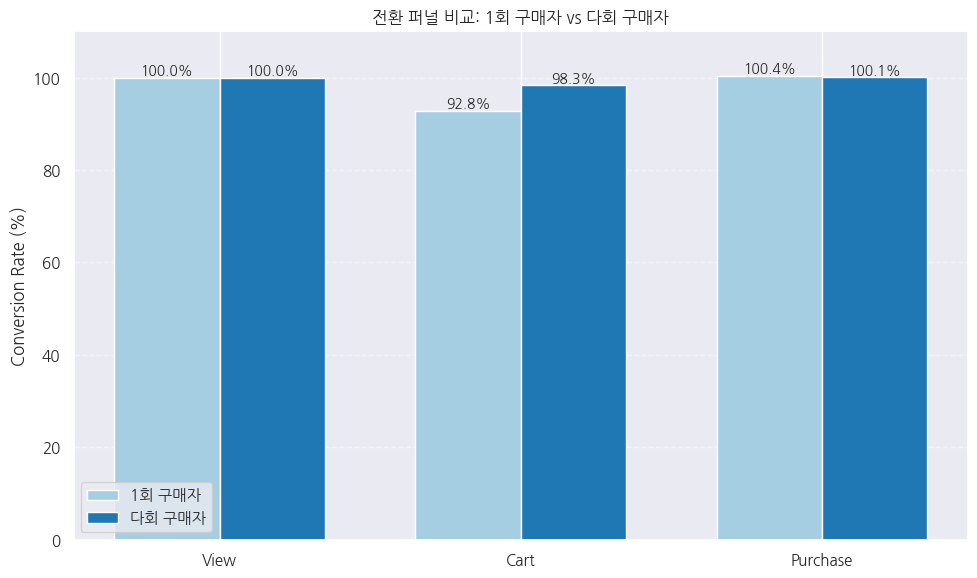

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 단계별 정의
stages = ['View', 'Cart', 'Purchase']
x = np.arange(len(stages))

# 전환율 (View 기준 100%)
one_time_rates = [1.0, 0.9283, 1.0039]     # 1회 구매자
multi_rates    = [1.0, 0.9834, 1.0009]     # 다회 구매자

# 막대 너비 설정
width = 0.35

# 시각화
plt.figure(figsize=(10, 6))
bars1 = plt.bar(x - width/2, [r * 100 for r in one_time_rates], width, label='1회 구매자', color='#a6cee3')
bars2 = plt.bar(x + width/2, [r * 100 for r in multi_rates], width, label='다회 구매자', color='#1f78b4')

# 텍스트 라벨링
for i in range(len(stages)):
    plt.text(x[i] - width/2, one_time_rates[i] * 100 + 0.5, f'{one_time_rates[i]*100:.1f}%', ha='center', fontsize=10)
    plt.text(x[i] + width/2, multi_rates[i] * 100 + 0.5, f'{multi_rates[i]*100:.1f}%', ha='center', fontsize=10)

# 그래프 설정
plt.xticks(x, stages)
plt.ylabel('Conversion Rate (%)')
plt.title('전환 퍼널 비교: 1회 구매자 vs 다회 구매자')
plt.ylim(0, 110)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show

Cart 전환율: 다회 구매자가 더 높음 (98.3% vs 92.8%) → 장바구니 진입률이 우수

Purchase 전환율: 두 그룹 모두 100% 넘지만, 이는 일부 view/cart 없이 직접 구매한 유저 포함됨

전체 퍼널 흐름이 다회 구매자 쪽에서 더 매끄럽고 손실 적음

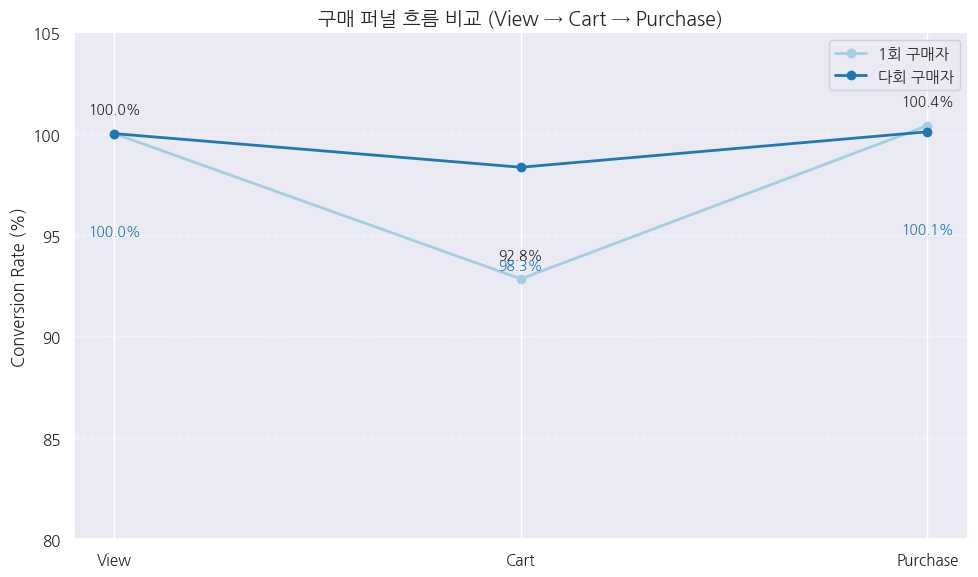

In [ ]:
# 어느 단계에서 유저가 빠지는지 강조하기 좋은 퍼널형 그래프
import matplotlib.pyplot as plt

# 단계와 전환율 정의 (% 단위)
stages = ['View', 'Cart', 'Purchase']
one_time_rates = [100, 92.83, 100.39]     # 실제 분석 결과 기반
multi_rates    = [100, 98.34, 100.09]

plt.figure(figsize=(10, 6))

# 선 그래프 그리기
plt.plot(stages, one_time_rates, marker='o', label='1회 구매자', color='#a6cee3', linewidth=2)
plt.plot(stages, multi_rates, marker='o', label='다회 구매자', color='#1f78b4', linewidth=2)

# 각 지점에 값 표시
for i in range(len(stages)):
    plt.text(i, one_time_rates[i] + 1, f'{one_time_rates[i]:.1f}%', ha='center', fontsize=10)
    plt.text(i, multi_rates[i] - 5, f'{multi_rates[i]:.1f}%', ha='center', fontsize=10, color='#1f78b4')

# 시각화 설정
plt.ylim(80, 105)  # y축 고정 → 과장 방지
plt.ylabel('Conversion Rate (%)')
plt.title('구매 퍼널 흐름 비교 (View → Cart → Purchase)', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

!! 1회 구매자의 핵심 문제:"초기 탐색 -> 장바구니 전환" (브랜드 신뢰 부족, 상품 정보 부족, 혜택 부족, 비교 대안 없음 등의 원인 가능)

| 문제 지점                       | 개선 방안                                                          |
| --------------------------- | -------------------------------------------------------------- |
| View → Cart 이탈률 높음 (1회 구매자) | 🔹 장바구니 진입 유도 배너 / 한정 쿠폰<br>🔹 상품 비교 기능 강화<br>🔹 후기 노출 / 신뢰 유도 |
| Cart → Purchase 거의 이탈 없음    | 🔹 장바구니 담긴 고객만 따로 리타겟팅해도 효과적                                   |
| View 후 Purchase 초과 현상       | 🔹 외부 유입 → 바로 구매자 존재<br>🔹 구매 전 여정이 짧은 고객 세그먼트가 있음             |

1회 구매자의 이탈은 “장바구니 진입 전”에 집중되어 있으며, 이 구간만 설계 개선해도 리텐션 향상이 가능하다.

* 재구매에 이른 고객들의 전형적인 행동 흐름 분석

| 항목                  | 분석 방식                 | 시사점                   |
| ------------------- | --------------------- | --------------------- |
| **view → cart 전환율** | 다회 구매자 vs 1회 구매자 비교   | 관심→구매 유도력 차이          |
| **cart 보유 시간**      | cart 이후 구매까지 평균 시간    | 구매 망설임/결정 시간 차이       |
| **브랜드/카테고리 다양성**    | 다회 구매자는 다양한 카테고리 탐색?  | 1회 구매자는 특정 상품군에만 관심?  |
| **세션 간격**           | 첫 방문 \~ 다음 방문까지 평균 시간 | 다음 방문을 유도할 마케팅 타이밍 판단 |
| **세션 수 / 머문 시간**    | 더 오래 탐색하고 비교했는가?      | 충동구매 vs 숙고구매 여부       |

| 항목               | 다회 구매자    | 1회 구매자  | 차이점                   |
| ---------------- | --------- | ------- | --------------------- |
| **평균 세션 수**      | **15.73** | 8.36    | 🔻 7.4개 세션 적음 (약 53%) |
| **평균 이벤트 수**     | **83.51** | 41.11   | 🔻 절반 수준              |
| **평균 탐색 카테고리 수** | **2.20**  | 1.86    | 🔻 약 15% 감소           |
| **평균 브랜드 수**     | **8.47**  | 5.74    | 🔻 약 32% 감소           |
| **평균 구매 간격(일)**  | **7.87일** | (해당 없음) | -                     |


#Cart 보유 시간 비교
시간 단위를 ‘시간(hour)’으로 계산해도 분석 목적에는 충분히 유의미하나, 분 단위보다 정밀도는 떨어질 수 있다.

In [ ]:
df = top_multi_df  # 다회 구매자용 전체 데이터

# 1. event_datetime 생성 (vectorized 방식)
df['event_datetime'] = pd.to_datetime(df['event_date']) + pd.to_timedelta(df['event_hour'], unit='h')

# 2. cart & purchase 이벤트 필터링
df_cart = df[df['event_type'] == 'cart']
df_purchase = df[df['event_type'] == 'purchase']

# 3. 세션별 가장 빠른 cart/purchase 시간 추출
cart_times = df_cart.groupby('user_session')['event_datetime'].min().to_frame(name='cart_time')
purchase_times = df_purchase.groupby('user_session')['event_datetime'].min().to_frame(name='purchase_time')

# 4. 공통 세션만 남기고 merge
merged = pd.merge(cart_times, purchase_times, left_index=True, right_index=True)

# 5. 시간차 계산
cart_hold_time = (merged['purchase_time'] - merged['cart_time']).dt.total_seconds() / 3600

# 6. 음수 제거 (올바른 순서만 필터링)
cart_hold_time = cart_hold_time[cart_hold_time >= 0]

# 7. 결과 출력
print(f"[다회 구매자] 평균 Cart 보유 시간 (시간): {cart_hold_time.mean():.2f}")

[다회 구매자] 평균 Cart 보유 시간 (시간): 1.46


In [ ]:
cart_hold_time_multi = cart_hold_time # 다회 구매자

In [ ]:
df = top_one_df  # 1회 구매자용 전체 데이터

# 1. event_datetime 생성 (vectorized 방식)
df['event_datetime'] = pd.to_datetime(df['event_date']) + pd.to_timedelta(df['event_hour'], unit='h')

# 2. cart & purchase 이벤트 필터링
df_cart = df[df['event_type'] == 'cart']
df_purchase = df[df['event_type'] == 'purchase']

# 3. 세션별 가장 빠른 cart/purchase 시간 추출
cart_times = df_cart.groupby('user_session')['event_datetime'].min().to_frame(name='cart_time')
purchase_times = df_purchase.groupby('user_session')['event_datetime'].min().to_frame(name='purchase_time')

# 4. 공통 세션만 남기고 merge
merged = pd.merge(cart_times, purchase_times, left_index=True, right_index=True)

# 5. 시간차 계산
cart_hold_time = (merged['purchase_time'] - merged['cart_time']).dt.total_seconds() / 3600

# 6. 음수 제거 (올바른 순서만 필터링)
cart_hold_time = cart_hold_time[cart_hold_time >= 0]

# 7. 결과 출력
print(f"[1회 구매자] 평균 Cart 보유 시간 (시간): {cart_hold_time.mean():.2f}")

[1회 구매자] 평균 Cart 보유 시간 (시간): 2.56


In [ ]:
cart_hold_time_one_time = cart_hold_time #1회 구매자

전략 제안: 'cart 보유 시간 기반 리텐션 마케팅'

| 타겟         | 조건                       | 액션                         |
| ---------- | ------------------------ | -------------------------- |
| **1회 구매자** | cart 후 2시간 이상 경과 & 구매 없음 | 💬 리마인드 푸시, 타임딜 할인 배너      |
| **다회 구매자** | cart 후 1시간 내 구매 경험 있음    | 🙌 신뢰도 높은 고객 → 추천 상품 노출    |
| **전체 대상**  | cart 후 3시간 넘는 고객         | 📉 이탈 우려군 → 무료배송/포인트 지급 알림 |

히스토플롯으로 분포 보기

In [ ]:
# 구간 정의
bins = [0, 1, 3, 24, 48, 9999]
labels = ['<1시간', '1~3시간', '3~24시간', '24~48시간', '48시간 이상']

# 카테고리 라벨링
one_time_cut = pd.cut(cart_hold_time_one_time, bins=bins, labels=labels, right=False)
multi_cut = pd.cut(cart_hold_time_multi, bins=bins, labels=labels, right=False)

# 비율 계산
one_time_ratio = one_time_cut.value_counts(normalize=True).sort_index()
multi_ratio = multi_cut.value_counts(normalize=True).sort_index()

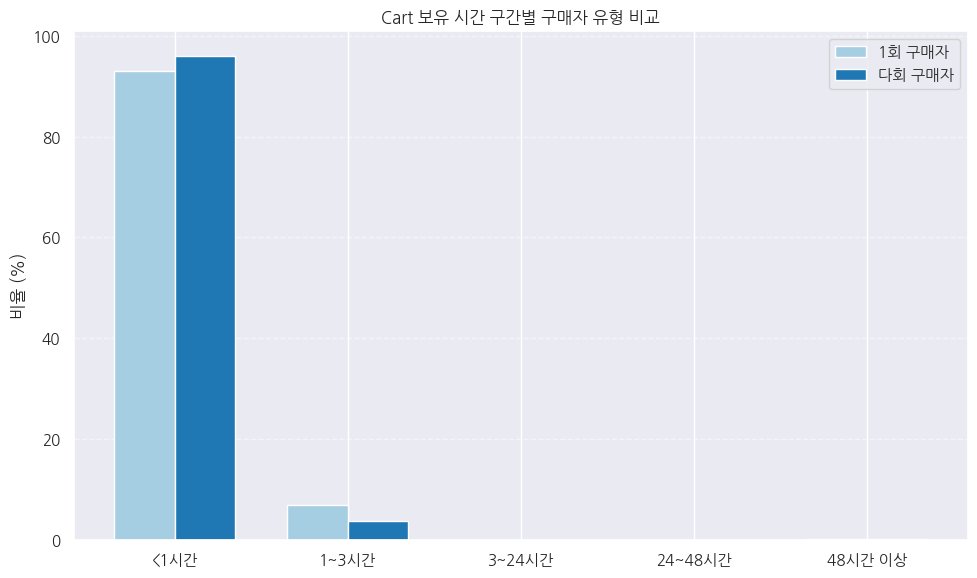

In [ ]:
# 그룹형 막대그래프
import numpy as np

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(10,6))
plt.bar(x - width/2, one_time_ratio.values * 100, width, label='1회 구매자', color='#a6cee3')
plt.bar(x + width/2, multi_ratio.values * 100, width, label='다회 구매자', color='#1f78b4')

plt.xticks(x, labels)
plt.ylabel('비율 (%)')
plt.title('Cart 보유 시간 구간별 구매자 유형 비교')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

cart 보유 시간 1시간 이상 고객 분포 확인

In [ ]:
# 1시간 이상 보유한 경우만 필터링
one_time_over1h = cart_hold_time_one_time[cart_hold_time_one_time >= 1]
multi_over1h = cart_hold_time_multi[cart_hold_time_multi >= 1]

In [ ]:
print(f"[1회 구매자] 1시간 이상 보유 비율: {len(one_time_over1h) / len(cart_hold_time_one_time) * 100:.2f}%")
print(f"[다회 구매자] 1시간 이상 보유 비율: {len(multi_over1h) / len(cart_hold_time_multi) * 100:.2f}%")

[1회 구매자] 1시간 이상 보유 비율: 7.10%
[다회 구매자] 1시간 이상 보유 비율: 3.93%


In [ ]:
# 1시간 이상만 다루므로 bins 조정
bins_1hplus = [1, 3, 24, 48, 9999]
labels_1hplus = ['1~3시간', '3~24시간', '24~48시간', '48시간 이상']

# cut
one_time_cut_1hplus = pd.cut(one_time_over1h, bins=bins_1hplus, labels=labels_1hplus, right=False)
multi_cut_1hplus = pd.cut(multi_over1h, bins=bins_1hplus, labels=labels_1hplus, right=False)

# 비율
one_time_ratio_1hplus = one_time_cut_1hplus.value_counts(normalize=True).sort_index()
multi_ratio_1hplus = multi_cut_1hplus.value_counts(normalize=True).sort_index()

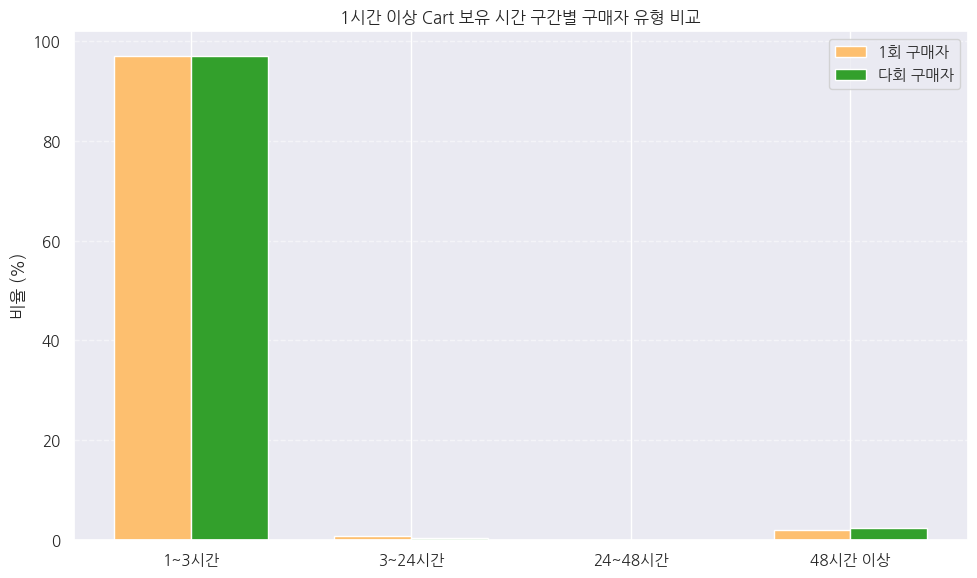

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(len(labels_1hplus))
width = 0.35

plt.figure(figsize=(10,6))
plt.bar(x - width/2, one_time_ratio_1hplus.values * 100, width, label='1회 구매자', color='#fdbf6f')
plt.bar(x + width/2, multi_ratio_1hplus.values * 100, width, label='다회 구매자', color='#33a02c')

plt.xticks(x, labels_1hplus)
plt.ylabel('비율 (%)')
plt.title('1시간 이상 Cart 보유 시간 구간별 구매자 유형 비교')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

- 대부분 1시간 이내 구매하지만, 이탈한 1회 구매자일수록 장시간 고민 후 구매한 비율이 더 높음 → 즉, 결정이 늦었던 유저일수록 재구매 가능성이 낮음.
- 빠르게 결정하는 유저일수록 재구매 확률이 높고 충성도가 높다.
→ 따라서, Cart 담은 후 1시간 이상 지난 유저에게 리마인드 마케팅 자동 발송 전략이 유의미해질 수 있음.
- 다회 구매자는 오래 두고 사는 사람도 일부 존재(48시간 이상)하지만, 이는 특이 사용자 행동 패턴

'electronics' 'appliances' 'construction'별 1회vs다회 구매자, cart 보유 시간

In [ ]:
# 분석 대상 카테고리
target_categories = ['electronics', 'appliances', 'construction']

one_time_target = top_one_df[top_one_df['category_lvl1'].isin(target_categories)].copy()
multi_time_target = top_multi_df[top_multi_df['category_lvl1'].isin(target_categories)].copy()

In [ ]:
# Cart 보유 시간 계산 함수
def calculate_cart_hold_hours(df, category_name):
    # 해당 카테고리 필터링
    category_df = df[df['category_lvl1'] == category_name].copy()

    # event_datetime 생성
    category_df['event_datetime'] = category_df['event_date'] + pd.to_timedelta(category_df['event_hour'], unit='h')
    category_df['event_datetime'] = pd.to_datetime(category_df['event_datetime'])

    # 장바구니, 구매 시점 추출
    cart_times = category_df[category_df['event_type'] == 'cart'].groupby('user_id')['event_datetime'].min()
    purchase_times = category_df[category_df['event_type'] == 'purchase'].groupby('user_id')['event_datetime'].min()

    # cart → purchase 연결
    merged = pd.merge(cart_times, purchase_times, on='user_id', suffixes=('_cart', '_purchase'))

    # 보유 시간 계산 (단위: 시간)
    hold_hours = (merged['event_datetime_purchase'] - merged['event_datetime_cart']).dt.total_seconds() / 3600

    return hold_hours

# 카테고리별 평균 Cart 보유 시간 저장
results = {}
for category in target_categories:
    one_time_hold = calculate_cart_hold_hours(one_time_target, category)
    multi_time_hold = calculate_cart_hold_hours(multi_time_target, category)

    results[category] = {
        '1회 구매자 평균': round(one_time_hold.mean(), 2),
        '다회 구매자 평균': round(multi_time_hold.mean(), 2)
    }

# 결과 데이터프레임 생성
cart_hold_summary_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': '카테고리'})

/tmp/ipython-input-1474793787.py:7: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized.
  category_df['event_datetime'] = category_df['event_date'] + pd.to_timedelta(category_df['event_hour'], unit='h')
/tmp/ipython-input-1474793787.py:7: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized.
  category_df['event_datetime'] = category_df['event_date'] + pd.to_timedelta(category_df['event_hour'], unit='h')
/tmp/ipython-input-1474793787.py:7: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized.
  category_df['event_datetime'] = category_df['event_date'] + pd.to_timedelta(category_df['event_hour'], unit='h')
/tmp/ipython-input-1474793787.py:7: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized.
  category_df['event_datetime'] = category_df['event_date'] + pd.to_timedelta(category_df['event_hour'], unit='h')
/tmp/ipython-input-147479378

In [ ]:
# 결과 출력
print("카테고리별 1회 vs 다회 구매자 평균 Cart 보유 시간 (단위: 시간)")
display(cart_hold_summary_df)

카테고리별 1회 vs 다회 구매자 평균 Cart 보유 시간 (단위: 시간)


,카테고리,1회 구매자 평균,다회 구매자 평균
0,electronics,43.72,9.24
1,appliances,61.14,23.80
2,construction,55.09,64.04


1. electronics, appliances
- 1회 구매자 → 더 오래 cart에 보유한 후 구매 → 의사결정 시간이 길지만 재방문 없이 단발 구매로 끝남

- 다회 구매자 → 비교적 빠르게 구매 → 쇼핑몰과의 신뢰나 익숙함이 있어 빠른 구매 + 반복 이용
 - 해당 제품군은 즉시 구매 유도 프로모션(ex. 타임세일, 장바구니 리마인드 알림 등)이 리텐션에 긍정적
2. construction
- 다회 구매자의 Cart 보유 시간이 오히려 더 김 (64.04시간) → 상품군 특성상 고관여 + 반복 구매자가 많을 수 있음 → 한 번 구매하면, 이후에도 심사숙고 후 재방문 구매하는 경향
 - 이 카테고리는 빠른 전환보다 신뢰 유지 중심 전략이 효과적 → 예: 상세 정보 제공, 리뷰 강화, 견적 비교 툴, 장바구니 장기 보존 등
 - *고관여 구매자: 단순히 상품을 사는 데 그치지 않고 시간, 노력, 정보 탐색을 많이 투자해서 신중하게 결정하는 소비자

In [ ]:
# to. 지연님
########################### 코드는 여기까지 입니다!!

In [ ]:
df = multi_buyer_df  # 다회 구매자용 전체 데이터 - 층화 샘플링 버전

# 1. event_datetime 생성 (vectorized 방식)
df['event_datetime'] = pd.to_datetime(df['event_date']) + pd.to_timedelta(df['event_hour'], unit='h')

# 2. cart & purchase 이벤트 필터링
df_cart = df[df['event_type'] == 'cart']
df_purchase = df[df['event_type'] == 'purchase']

# 3. 세션별 가장 빠른 cart/purchase 시간 추출
cart_times = df_cart.groupby('user_session')['event_datetime'].min().to_frame(name='cart_time')
purchase_times = df_purchase.groupby('user_session')['event_datetime'].min().to_frame(name='purchase_time')

# 4. 공통 세션만 남기고 merge
merged = pd.merge(cart_times, purchase_times, left_index=True, right_index=True)

# 5. 시간차 계산
cart_hold_time = (merged['purchase_time'] - merged['cart_time']).dt.total_seconds() / 3600

# 6. 음수 제거 (올바른 순서만 필터링)
cart_hold_time = cart_hold_time[cart_hold_time >= 0]

# 7. 결과 출력
print(f"[다회 구매자] 평균 Cart 보유 시간 (시간): {cart_hold_time.mean():.2f}")

/tmp/ipython-input-3775089124.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['event_datetime'] = pd.to_datetime(df['event_date']) + pd.to_timedelta(df['event_hour'], unit='h')


[다회 구매자] 평균 Cart 보유 시간 (시간): 2.74


In [ ]:
cart_hold_time_multi = cart_hold_time # 다회 구매자

In [ ]:
df = one_time_df  # 1회 구매자용 전체 데이터 - 층화 샘플링 버전

# 1. event_datetime 생성 (vectorized 방식)
df['event_datetime'] = pd.to_datetime(df['event_date']) + pd.to_timedelta(df['event_hour'], unit='h')

# 2. cart & purchase 이벤트 필터링
df_cart = df[df['event_type'] == 'cart']
df_purchase = df[df['event_type'] == 'purchase']

# 3. 세션별 가장 빠른 cart/purchase 시간 추출
cart_times = df_cart.groupby('user_session')['event_datetime'].min().to_frame(name='cart_time')
purchase_times = df_purchase.groupby('user_session')['event_datetime'].min().to_frame(name='purchase_time')

# 4. 공통 세션만 남기고 merge
merged = pd.merge(cart_times, purchase_times, left_index=True, right_index=True)

# 5. 시간차 계산
cart_hold_time = (merged['purchase_time'] - merged['cart_time']).dt.total_seconds() / 3600

# 6. 음수 제거 (올바른 순서만 필터링)
cart_hold_time = cart_hold_time[cart_hold_time >= 0]

# 7. 결과 출력
print(f"[1회 구매자] 평균 Cart 보유 시간 (시간): {cart_hold_time.mean():.2f}")

/tmp/ipython-input-4203631259.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['event_datetime'] = pd.to_datetime(df['event_date']) + pd.to_timedelta(df['event_hour'], unit='h')


[1회 구매자] 평균 Cart 보유 시간 (시간): 1.30


In [ ]:
cart_hold_time_one_time = cart_hold_time #1회 구매자

In [ ]:
# 히스토플롯으로 분포 보기 - 층화 샘플링 버전
# 구간 정의
bins = [0, 1, 3, 24, 48, 9999]
labels = ['<1시간', '1~3시간', '3~24시간', '24~48시간', '48시간 이상']

# 카테고리 라벨링
one_time_cut = pd.cut(cart_hold_time_one_time, bins=bins, labels=labels, right=False)
multi_cut = pd.cut(cart_hold_time_multi, bins=bins, labels=labels, right=False)

# 비율 계산
one_time_ratio = one_time_cut.value_counts(normalize=True).sort_index()
multi_ratio = multi_cut.value_counts(normalize=True).sort_index()

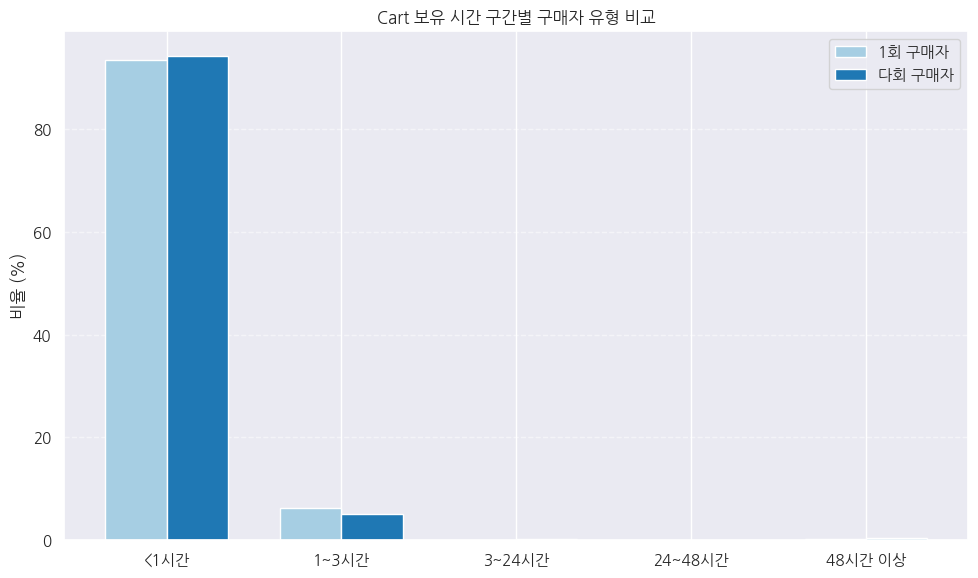

In [ ]:
# 그룹형 막대그래프 - 층화 샘플링 버전
import numpy as np

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(10,6))
plt.bar(x - width/2, one_time_ratio.values * 100, width, label='1회 구매자', color='#a6cee3')
plt.bar(x + width/2, multi_ratio.values * 100, width, label='다회 구매자', color='#1f78b4')

plt.xticks(x, labels)
plt.ylabel('비율 (%)')
plt.title('Cart 보유 시간 구간별 구매자 유형 비교')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
# 1시간 이상 보유한 경우만 필터링 -층화 샘플링 버전
one_time_over1h = cart_hold_time_one_time[cart_hold_time_one_time >= 1]
multi_over1h = cart_hold_time_multi[cart_hold_time_multi >= 1]

print(f"[1회 구매자] 1시간 이상 보유 비율: {len(one_time_over1h) / len(cart_hold_time_one_time) * 100:.2f}%")
print(f"[다회 구매자] 1시간 이상 보유 비율: {len(multi_over1h) / len(cart_hold_time_multi) * 100:.2f}%")

[1회 구매자] 1시간 이상 보유 비율: 6.40%
[다회 구매자] 1시간 이상 보유 비율: 5.59%


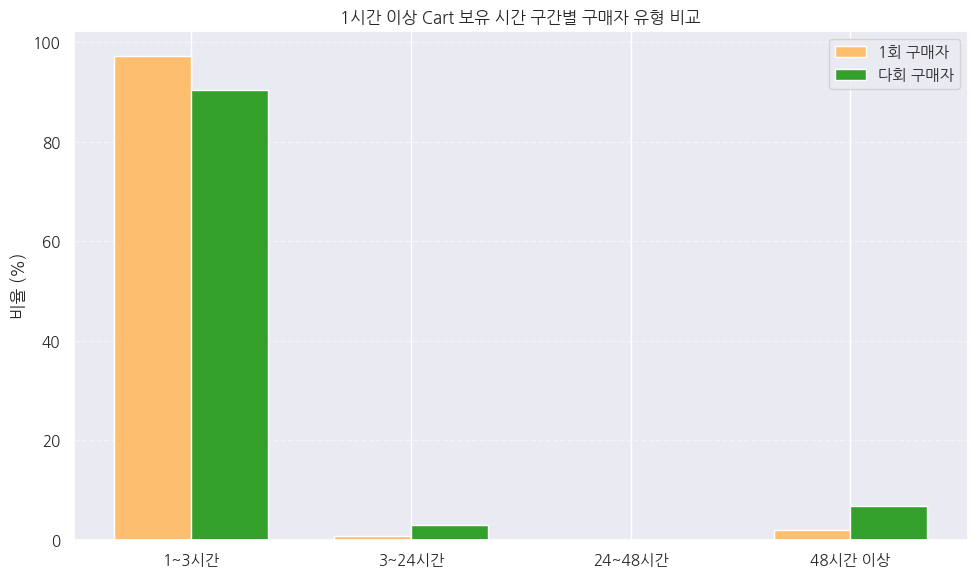

In [ ]:
# 1시간 이상만 다루므로 bins 조정
bins_1hplus = [1, 3, 24, 48, 9999]
labels_1hplus = ['1~3시간', '3~24시간', '24~48시간', '48시간 이상']

# cut
one_time_cut_1hplus = pd.cut(one_time_over1h, bins=bins_1hplus, labels=labels_1hplus, right=False)
multi_cut_1hplus = pd.cut(multi_over1h, bins=bins_1hplus, labels=labels_1hplus, right=False)

# 비율
one_time_ratio_1hplus = one_time_cut_1hplus.value_counts(normalize=True).sort_index()
multi_ratio_1hplus = multi_cut_1hplus.value_counts(normalize=True).sort_index()

import numpy as np
import matplotlib.pyplot as plt

x = np.arange(len(labels_1hplus))
width = 0.35

plt.figure(figsize=(10,6))
plt.bar(x - width/2, one_time_ratio_1hplus.values * 100, width, label='1회 구매자', color='#fdbf6f')
plt.bar(x + width/2, multi_ratio_1hplus.values * 100, width, label='다회 구매자', color='#33a02c')

plt.xticks(x, labels_1hplus)
plt.ylabel('비율 (%)')
plt.title('1시간 이상 Cart 보유 시간 구간별 구매자 유형 비교')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

# -------------------------------------------------------------------
# 1) 분석 대상 카테고리 지정
# -------------------------------------------------------------------
target_categories = ['electronics', 'appliances', 'construction']

# -------------------------------------------------------------------
# 2) Cart 보유 시간 계산 함수 정의
# -------------------------------------------------------------------
def calculate_cart_hold_hours(df, category_name):
    # 2.1) 해당 카테고리 필터링
    cat = df[df['category_lvl1'] == category_name].copy()

    # 2.2) 타입 변환
    cat['event_date'] = pd.to_datetime(cat['event_date'])
    cat['event_hour'] = cat['event_hour'].astype(int)

    # 2.3) event_datetime 생성
    cat['event_datetime'] = cat['event_date'] + pd.to_timedelta(cat['event_hour'], unit='h')

    # 2.4) cart / purchase 시점 추출
    carts = (
        cat[cat['event_type'] == 'cart']
        .groupby('user_id')['event_datetime']
        .min()
        .rename('event_cart')
        .reset_index()
    )
    purchases = (
        cat[cat['event_type'] == 'purchase']
        .groupby('user_id')['event_datetime']
        .min()
        .rename('event_purchase')
        .reset_index()
    )

    # 2.5) user_id 기준 매칭 후 "purchase >= cart" 필터링
    merged = pd.merge(carts, purchases, on='user_id')
    merged = merged[merged['event_purchase'] >= merged['event_cart']]

    # 2.6) 보유 시간 계산 (단위: 시간)
    hold_hours = (merged['event_purchase'] - merged['event_cart']).dt.total_seconds() / 3600.0

    return hold_hours

# -------------------------------------------------------------------
# 3) 1회/다회 구매자 데이터 준비
# -------------------------------------------------------------------
one_time_target  = one_time_df[one_time_df['category_lvl1'].isin(target_categories)].copy()
multi_time_target = multi_buyer_df[multi_buyer_df['category_lvl1'].isin(target_categories)].copy()

# -------------------------------------------------------------------
# 4) 카테고리별 평균 Cart 보유 시간 계산 및 요약
# -------------------------------------------------------------------
results = []
for cat in target_categories:
    one_hold   = calculate_cart_hold_hours(one_time_target, cat)
    multi_hold = calculate_cart_hold_hours(multi_time_target, cat)

    results.append({
        '카테고리': cat,
        '1회 구매자 평균(시간)': round(one_hold.mean(), 2),
        '다회 구매자 평균(시간)': round(multi_hold.mean(), 2)
    })

cart_hold_summary_df = pd.DataFrame(results)

# -------------------------------------------------------------------
# 5) 결과 출력
# -------------------------------------------------------------------
print("📊 카테고리별 1회 vs 다회 구매자 평균 Cart 보유 시간")
display(cart_hold_summary_df)

📊 카테고리별 1회 vs 다회 구매자 평균 Cart 보유 시간


,카테고리,1회 구매자 평균(시간),다회 구매자 평균(시간)
0,electronics,218.33,307.37
1,appliances,261.86,379.85
2,construction,247.89,319.95


In [ ]:
# 이상치 때문에 다시
import pandas as pd
import numpy as np

def calculate_cart_hold_hours(df, category_name, max_hours=48):
    # 1) 해당 카테고리만 필터
    cat = df[df['category_lvl1'] == category_name].copy()

    # 2) 타입 변환
    cat['event_date'] = pd.to_datetime(cat['event_date'])
    cat['event_hour'] = cat['event_hour'].astype(int)

    # 3) event_dt 생성
    cat['event_dt'] = cat['event_date'] + pd.to_timedelta(cat['event_hour'], unit='h')

    # 4) 유저별로 cart → purchase 매칭
    hold_list = []
    for user_id, grp in cat.groupby('user_id'):
        carts = np.sort(grp.loc[grp['event_type']=='cart',    'event_dt'].values)
        buys  = np.sort(grp.loc[grp['event_type']=='purchase','event_dt'].values)
        if len(buys) == 0 or len(carts) == 0:
            continue

        # 각 cart 시간에 대해, buys 배열에서 첫 번째 이후 시점 찾기
        idxs = np.searchsorted(buys, carts, side='left')
        for cart_time, idx in zip(carts, idxs):
            if idx < len(buys):
                # numpy.timedelta64 를 시간(h) 단위로 변환
                delta_h = (buys[idx] - cart_time) / np.timedelta64(1, 'h')
                # 0~max_hours 범위만 사용
                if 0 <= delta_h <= max_hours:
                    hold_list.append(delta_h)

    return pd.Series(hold_list, name='hold_h')

# -------------------------------------------------------------------
# 3) 1회/다회 구매자용 DataFrame 준비
# -------------------------------------------------------------------
one_time = one_time_df[one_time_df['category_lvl1'].isin(target_categories)]
multi_time = multi_buyer_df[multi_buyer_df['category_lvl1'].isin(target_categories)]

# -------------------------------------------------------------------
# 4) 카테고리별 요약 테이블 작성
# -------------------------------------------------------------------
rows = []
for cat in target_categories:
    one_h  = calculate_cart_hold_hours(one_time,  cat, max_hours=48)
    multi_h = calculate_cart_hold_hours(multi_time,cat, max_hours=48)

    rows.append({
        '카테고리': cat,
        '1회 구매자 평균(시간)':   round(one_h.mean(),   2),
        '다회 구매자 평균(시간)': round(multi_h.mean(), 2),
        '1회 구매자 중앙값(시간)': round(one_h.median(),   2),
        '다회 구매자 중앙값(시간)': round(multi_h.median(), 2),
        '1회 구매자 건수': len(one_h),
        '다회 구매자 건수': len(multi_h),
    })

cart_hold_summary_df = pd.DataFrame(rows)

# -------------------------------------------------------------------
# 5) 결과 출력
# -------------------------------------------------------------------
print("📊 48시간 이내 Cart 보유 시간 (mean & median & count)")
display(cart_hold_summary_df)

📊 48시간 이내 Cart 보유 시간 (mean & median & count)


,카테고리,1회 구매자 평균(시간),다회 구매자 평균(시간),1회 구매자 중앙값(시간),다회 구매자 중앙값(시간),1회 구매자 건수,다회 구매자 건수
0,electronics,4.72,9.59,0.0,1.0,3837,2172
1,appliances,4.01,8.29,0.0,0.0,2383,1033
2,construction,4.82,9.73,0.0,1.0,7529,6051


In [ ]:
# 1회 구매자, 다회 구매자 양상이 원본 데이터와 다르게 나타나는 이슈

#주력 상품 3개 각 구매 주기 리텐션 적용하여 고객 세그먼트 분류
- 'electronics' : 자주(<=2일), 보통(3~4일), 드문(>=5일)
- 'appliances' : 자주(<=3일), 보통(4~6일), 드문(>=7일)
- 'construction' : 자주(<=2일), 보통(3일), 드문(>=4일)

In [ ]:
# # 주력 상품 구매자 전체의 cart 보유 시간별 이탈률 분석 -> 세션 다운
# # 1회 + 다회 구매자 데이터 결합
# all_df = pd.concat([top_one_df, top_multi_df], ignore_index=True)

# # event_datetime 생성
# all_df['event_datetime'] = all_df['event_date'] + pd.to_timedelta(all_df['event_hour'], unit='h')
# all_df['event_datetime'] = pd.to_datetime(all_df['event_datetime'])  # datetime 명시적 변환

# # 장바구니 담은 시간 (최초 cart 시점)
# cart_times = all_df[all_df['event_type'] == 'cart'].groupby('user_id')['event_datetime'].min()

# # 구매 시간 (최초 purchase 시점)
# purchase_times = all_df[all_df['event_type'] == 'purchase'].groupby('user_id')['event_datetime'].min()

# # cart → purchase 연결
# merged = pd.merge(cart_times, purchase_times, on='user_id', suffixes=('_cart', '_purchase'))

# # 보유 시간 계산 (단위: 시간)
# cart_hold_time_all = (merged['event_datetime_purchase'] - merged['event_datetime_cart']).dt.total_seconds() / 3600

#리텐션 패턴 탐색 (이탈 vs 재구매)

목적: 재구매한 고객과 이탈한 고객의 행동 차이 도출

리텐션 기준:
'드문' 고객의 평균 재구매 주기를 기준으로 cutoff 설정 → cutoff 이전에 2회 이상 구매한 고객은 리텐션, 아니라면 이탈

- 리텐션 그룹 vs 이탈 그룹의 행동 패턴 비교:

첫 방문 이후 구매까지 평균 시간

뷰/카트 횟수, 세션 수, 체류 시간, 주말/평일 이용 패턴

주력 vs 비주력 상품군 교차 사용 여부 (주력만 구매 vs 비주력 전환 여부)